In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from collections import deque
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score 
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, auc
from eli5.sklearn import PermutationImportance
from eli5.lightgbm import explain_weights_lightgbm
from xgboost import XGBClassifier
from collections import defaultdict
import shap
import eli5
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#the data used in this excercise was sourced from http://www.football-data.co.uk
df = pd.read_csv('./data/E0.csv')
df = df.append(pd.read_csv('./data/E0_2018.csv')).reset_index(drop=True)
print(df.head())

   AC  AF  AR  AS  AST  AY      AwayTeam  B365A  B365D  B365H  ...   PSCH  \
0   4  12   0   6    3   1     Leicester   6.50    4.5   1.53  ...   1.49   
1  10   9   0  14    4   2      Man City   1.33    5.5  11.00  ...  11.75   
2   5  11   0  10    5   3       Burnley  15.00    6.5   1.25  ...   1.33   
3   9  19   0   8    6   3  Huddersfield   5.00    3.6   1.83  ...   1.79   
4   7  10   0   9    1   1         Stoke   5.75    3.8   1.70  ...   1.82   

    PSD    PSH      Referee    VCA   VCD    VCH    WHA  WHD    WHH  
0  4.55   1.53       M Dean   6.50  4.50   1.53   6.00  4.2   1.53  
1  5.55  10.95     M Oliver   1.33  5.50  10.00   1.33  4.8  10.00  
2  6.30   1.26     C Pawson  15.00  6.25   1.25  13.00  5.5   1.25  
3  3.58   1.83       J Moss   5.00  3.60   1.83   5.00  3.3   1.80  
4  3.83   1.70  N Swarbrick   5.75  3.80   1.70   5.50  3.5   1.70  

[5 rows x 65 columns]


/home/srooney/.local/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 65 columns):
AC          569 non-null int64
AF          569 non-null int64
AR          569 non-null int64
AS          569 non-null int64
AST         569 non-null int64
AY          569 non-null int64
AwayTeam    569 non-null object
B365A       569 non-null float64
B365D       569 non-null float64
B365H       569 non-null float64
BWA         569 non-null float64
BWD         569 non-null float64
BWH         569 non-null float64
Bb1X2       569 non-null int64
BbAH        569 non-null int64
BbAHh       569 non-null float64
BbAv<2.5    569 non-null float64
BbAv>2.5    569 non-null float64
BbAvA       569 non-null float64
BbAvAHA     569 non-null float64
BbAvAHH     569 non-null float64
BbAvD       569 non-null float64
BbAvH       569 non-null float64
BbMx<2.5    569 non-null float64
BbMx>2.5    569 non-null float64
BbMxA       569 non-null float64
BbMxAHA     569 non-null float64
BbMxAHH     569 non-n

In [3]:
# There appears to be a set of odds that were not included in the 2018-2019 season, we'll remove these.
df = df.dropna(axis=1, how="any")

In [4]:
# Lets calculate the win % of the three outcomes from the matches.
res = dict(df.FTR.value_counts())
print('Home Team: {}%'.format(round(res['H']/(sum(res.values())), 2)),
     '\nAway Team: {}%'.format(round(res['A']/(sum(res.values())), 2)),
     '\nDraw: {}%'.format(round(res['D']/(sum(res.values())), 2)))

Home Team: 0.46% 
Away Team: 0.3% 
Draw: 0.24%


<h3>Over the past two EPL seasons, the home team has won 46% of matches. This will mark our baseline, if we picked home team to win every game we would be correct 46% of the time based of this data.</h3>

In [5]:
df.loc[df['FTR'] == 'H'].describe()

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,BWA,...,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,...,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.00000,259.000000
mean,4.359073,10.579151,0.069498,9.694981,2.961390,1.571429,8.014826,4.989344,2.204903,7.368340,...,5.043436,2.225019,5.013552,2.216448,8.268803,4.960734,2.206834,7.571699,4.69471,2.183707
std,2.694817,3.464732,0.254792,4.376161,1.982104,1.215897,6.853486,2.212443,1.531899,5.949594,...,2.400835,1.492921,2.223686,1.527201,7.230835,2.192337,1.518672,6.372562,1.98715,1.497926
min,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.300000,3.000000,1.080000,1.300000,...,2.910000,1.070000,2.990000,1.100000,1.300000,3.000000,1.050000,1.300000,2.90000,1.060000
25%,2.000000,8.000000,0.000000,7.000000,1.000000,1.000000,3.200000,3.400000,1.280000,3.100000,...,3.405000,1.305000,3.440000,1.300000,3.190000,3.400000,1.300000,3.050000,3.30000,1.295000
50%,4.000000,10.000000,0.000000,9.000000,3.000000,1.000000,5.000000,3.900000,1.800000,4.750000,...,3.910000,1.810000,3.940000,1.830000,5.000000,3.900000,1.830000,4.600000,3.75000,1.830000
75%,6.000000,13.000000,0.000000,13.000000,4.000000,2.000000,12.000000,6.000000,2.450000,10.500000,...,5.990000,2.480000,6.105000,2.480000,11.750000,6.000000,2.450000,11.000000,5.50000,2.450000
max,13.000000,21.000000,1.000000,25.000000,9.000000,6.000000,34.000000,13.000000,12.000000,31.000000,...,15.000000,11.680000,13.000000,11.960000,34.000000,13.000000,12.000000,29.000000,13.00000,11.000000


In [6]:
df.loc[df['FTR'] == 'A'].describe()

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,BWA,...,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,...,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,5.040462,10.526012,0.052023,12.936416,5.375723,1.572254,2.928613,4.089306,4.834335,2.833873,...,4.123295,4.898671,4.122717,4.777341,2.920058,4.093526,4.845318,2.878092,3.901329,4.549595
std,2.810608,3.434718,0.222718,4.648268,2.288213,1.230303,2.575406,1.099613,3.538646,2.316607,...,1.097950,3.398462,1.082216,3.342071,2.475306,1.079295,3.512443,2.594377,0.947078,3.122610
min,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.160000,3.000000,1.140000,1.150000,...,2.930000,1.170000,3.050000,1.140000,1.170000,3.000000,1.150000,1.150000,3.000000,1.120000
25%,3.000000,8.000000,0.000000,9.000000,4.000000,1.000000,1.570000,3.390000,2.370000,1.570000,...,3.380000,2.350000,3.430000,2.370000,1.600000,3.400000,2.380000,1.570000,3.300000,2.300000
50%,5.000000,11.000000,0.000000,13.000000,5.000000,1.000000,2.250000,3.750000,3.390000,2.150000,...,3.740000,3.450000,3.750000,3.440000,2.250000,3.750000,3.300000,2.150000,3.600000,3.300000
75%,7.000000,13.000000,0.000000,16.000000,7.000000,2.000000,3.390000,4.330000,6.500000,3.300000,...,4.480000,6.660000,4.450000,6.350000,3.400000,4.400000,6.500000,3.300000,4.200000,6.000000
max,13.000000,21.000000,1.000000,30.000000,14.000000,5.000000,21.000000,10.000000,23.000000,18.500000,...,8.650000,21.630000,9.390000,21.060000,21.000000,9.500000,20.000000,23.000000,8.500000,17.000000


In [7]:
df.loc[df['FTR'] == 'D'].describe()

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,BWA,...,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,4.321168,10.613139,0.080292,10.744526,3.722628,1.744526,4.608467,3.967153,2.837299,4.353504,...,3.957153,2.904526,3.993650,2.871752,4.524307,3.943869,2.874599,4.353723,3.763358,2.764672
std,2.765157,3.601977,0.272742,4.616195,2.049856,1.345085,4.197709,1.282850,1.842858,3.605274,...,1.352364,1.914134,1.309503,1.944622,3.720694,1.239689,1.948618,3.560591,0.985630,1.704503
min,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.280000,3.000000,1.080000,1.250000,...,2.890000,1.080000,2.950000,1.090000,1.250000,3.000000,1.060000,1.250000,2.900000,1.110000
25%,2.000000,8.000000,0.000000,7.000000,2.000000,1.000000,2.540000,3.250000,1.850000,2.500000,...,3.260000,1.860000,3.300000,1.880000,2.550000,3.250000,1.850000,2.600000,3.200000,1.850000
50%,4.000000,10.000000,0.000000,11.000000,4.000000,2.000000,3.390000,3.500000,2.370000,3.250000,...,3.510000,2.420000,3.510000,2.360000,3.400000,3.500000,2.380000,3.250000,3.400000,2.380000
75%,6.000000,13.000000,0.000000,14.000000,5.000000,3.000000,4.500000,4.000000,2.890000,4.500000,...,3.990000,3.080000,4.060000,2.960000,4.600000,4.000000,3.000000,4.500000,3.800000,2.880000
max,13.000000,26.000000,1.000000,26.000000,9.000000,7.000000,34.000000,13.000000,13.000000,29.000000,...,14.400000,13.500000,13.500000,13.000000,26.000000,13.000000,13.000000,26.000000,9.000000,12.000000


<h3>Comparing the summary statistics of our three outcomes we can see that the betting odds for the true outcome has the lowest mean (the betting favourite) except for the Draw result where the Home team has on average lower odds. This implies that there may be a common trend where by a home team favourite will often draw. This may be a consideration when evaluating our classifier as this could result in some false positives.</h3>

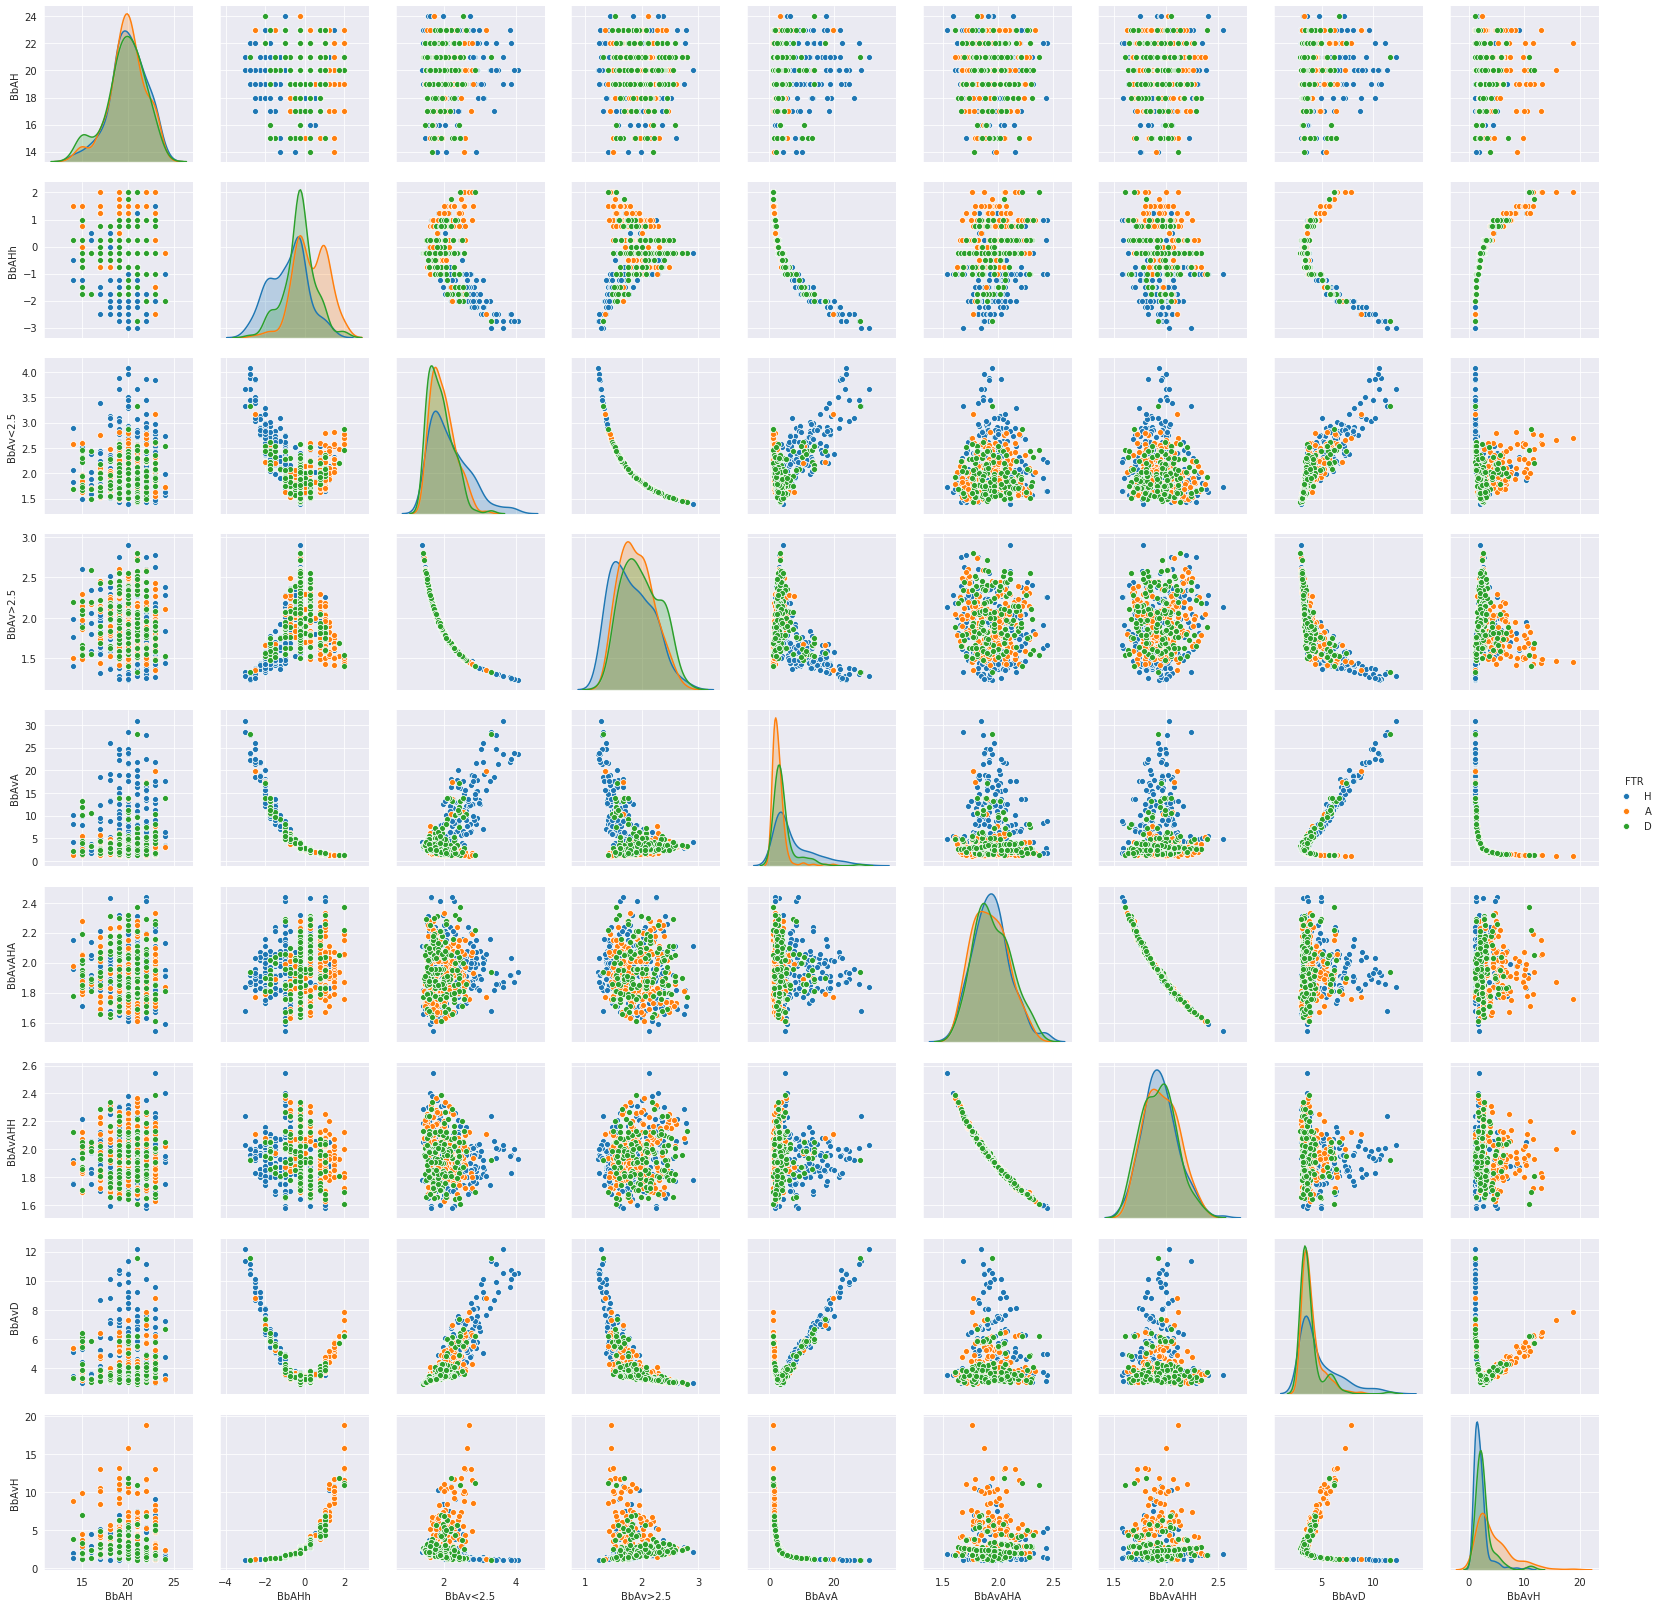

In [8]:
sns.set_style("darkgrid")
sns.pairplot(df[[x for x in list(df) if re.match(r'BbA\w', x)]+["FTR"]], hue="FTR")

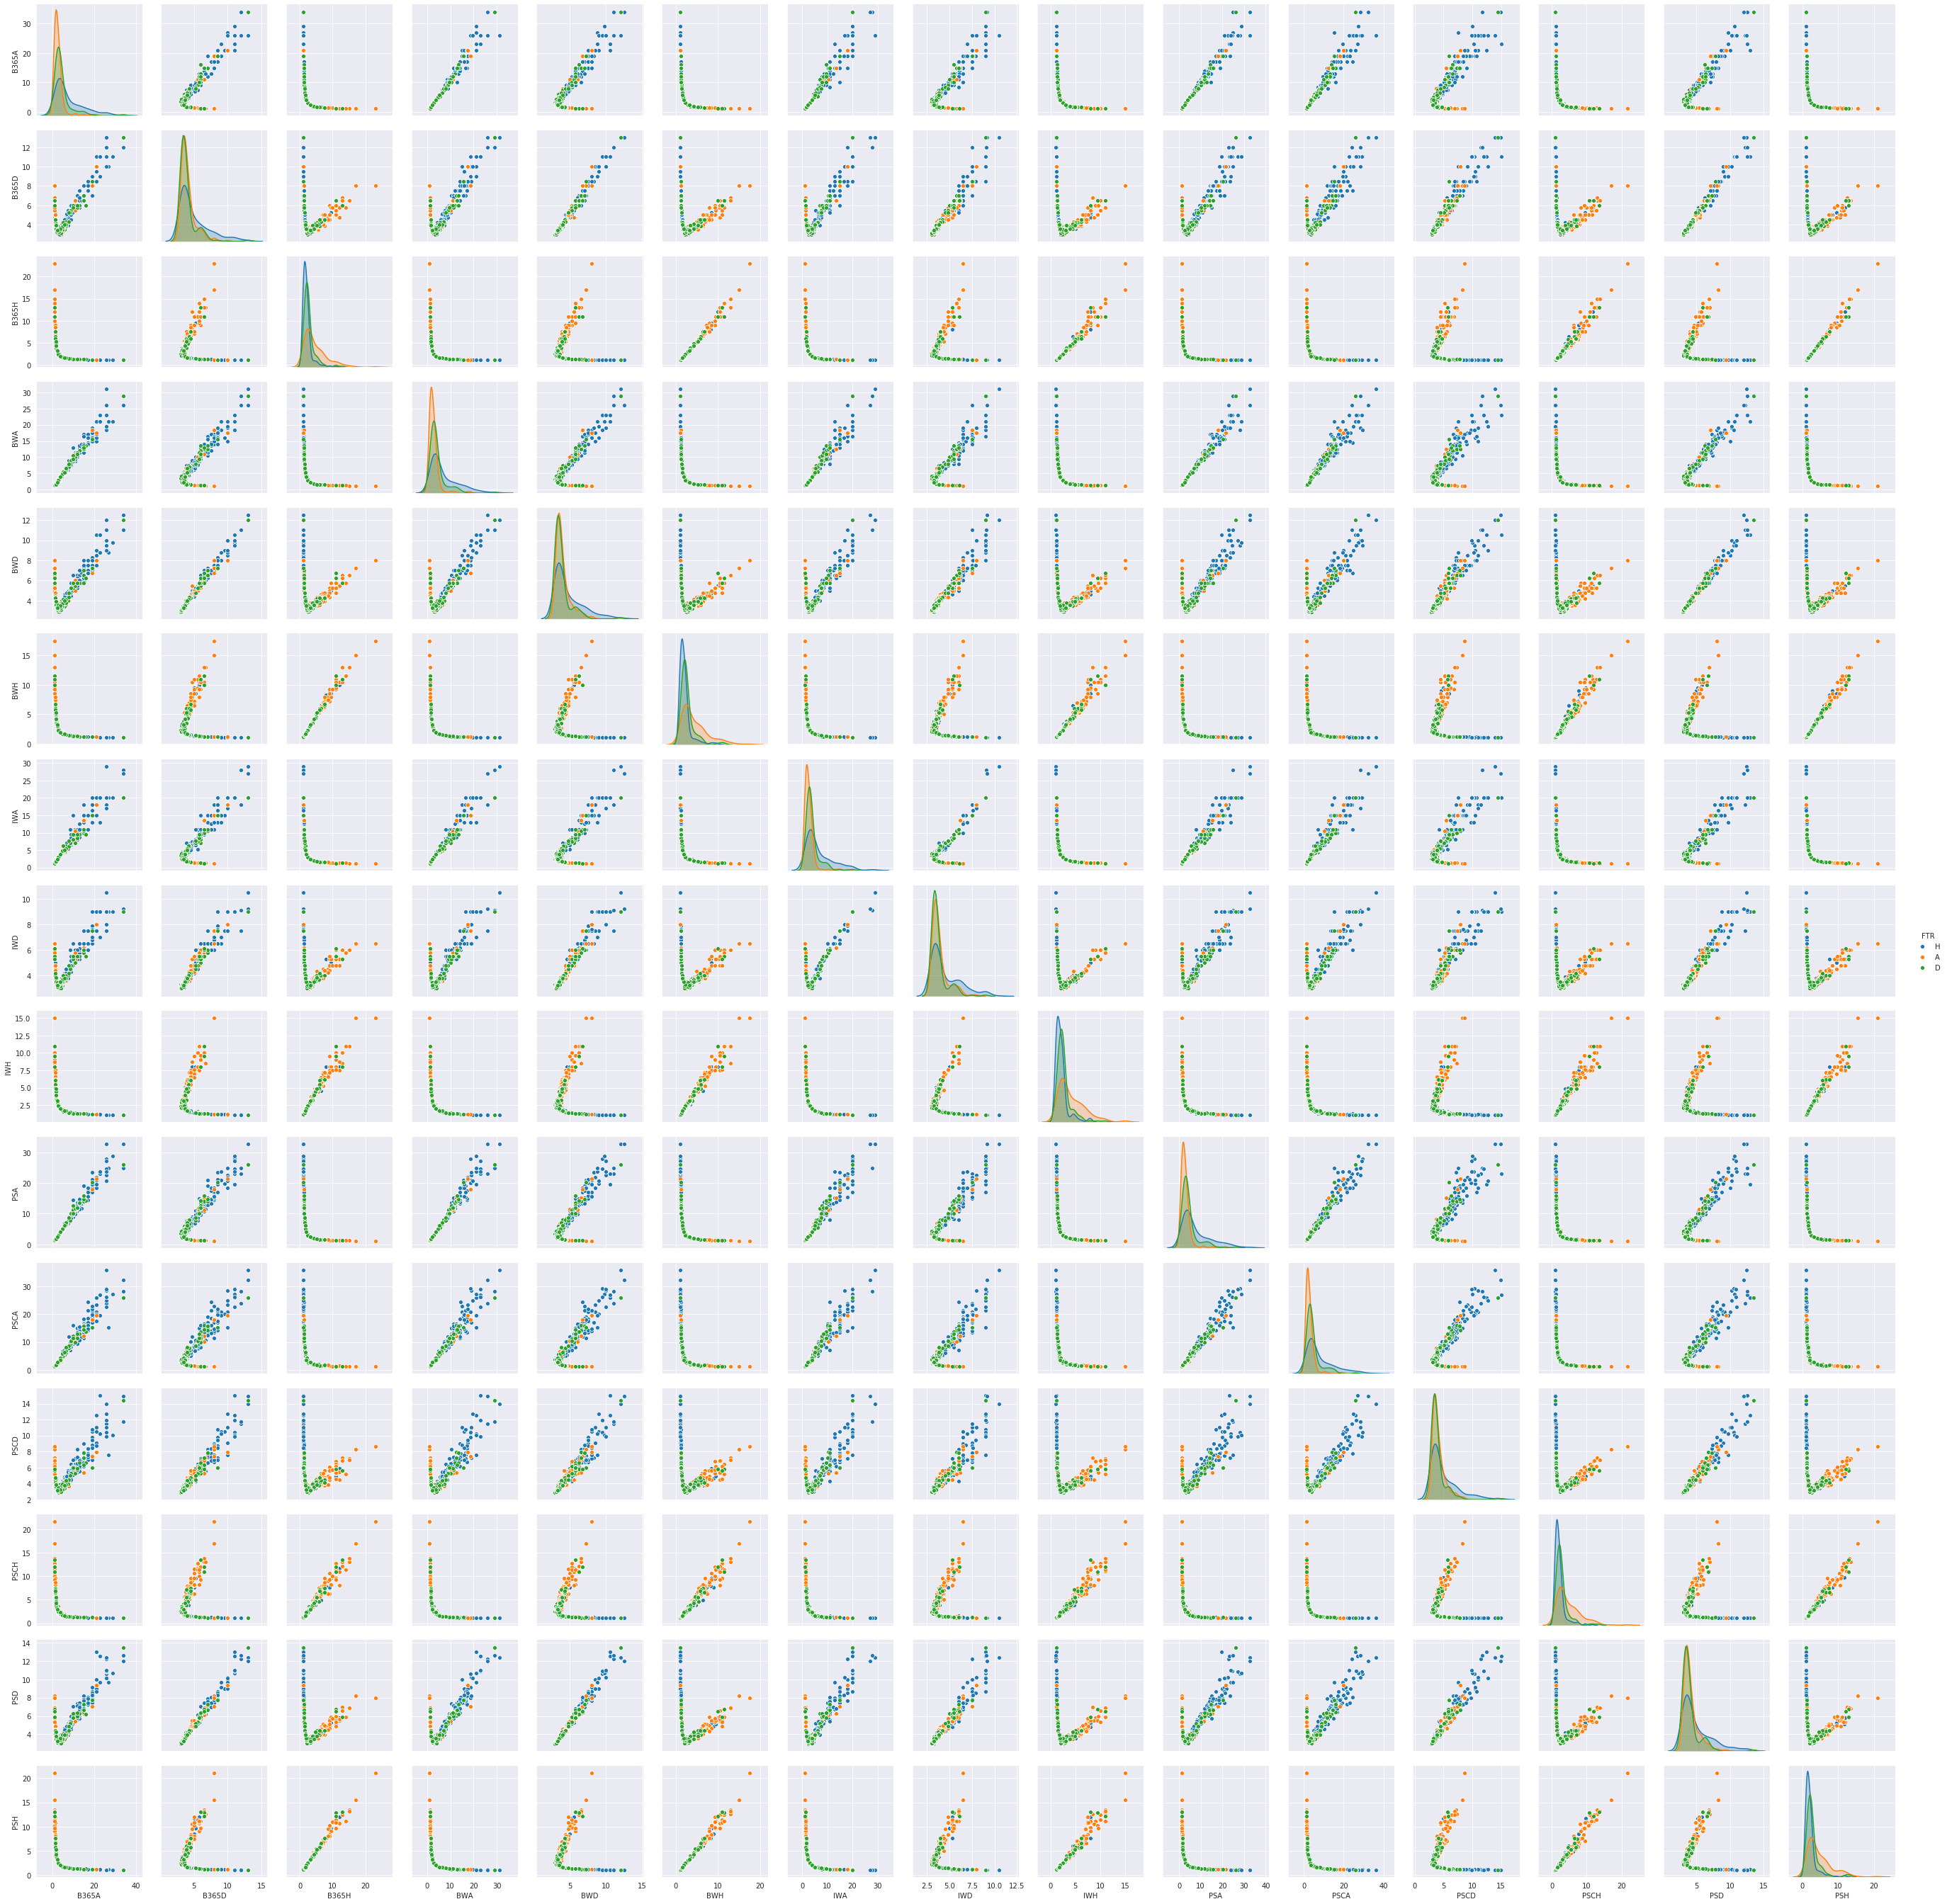

In [9]:
sns.pairplot(df[['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH','IWA', 'IWD', 'IWH',
                 'PSA', 'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'FTR']], hue="FTR")

<h3>We can see that most betting odds have a linear correlation when comparing outcome to outcome, dispersing a little more as the odds go up (which bookmakers tend to do to give the best price on an under dog).</h3>

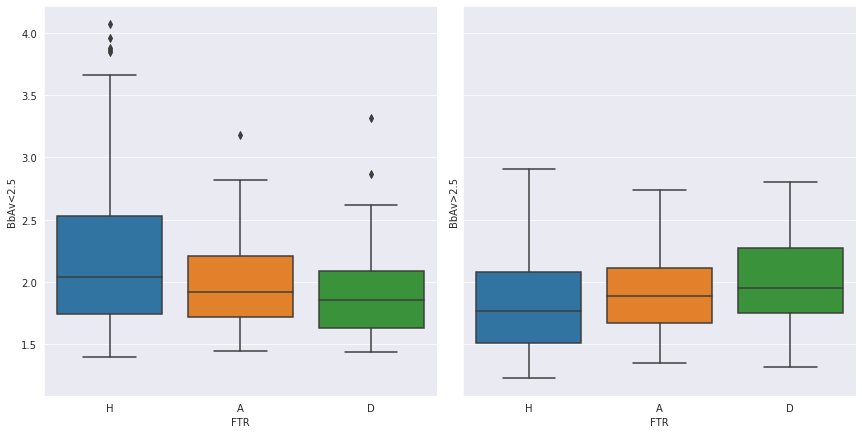

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.tight_layout()
sns.catplot(y="BbAv<2.5", x="FTR", kind="box", data=df, ax=ax1)
sns.catplot(y="BbAv>2.5", x="FTR", kind="box", data=df, ax=ax2)
plt.close()
plt.close(2)

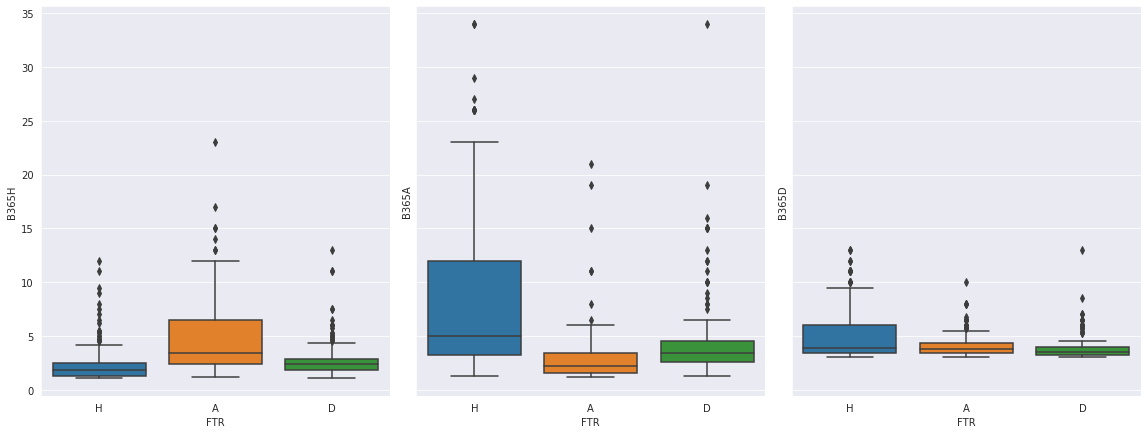

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16,6))
fig.tight_layout()
sns.catplot(y="B365H", x="FTR", kind="box", data=df, ax=ax1)
sns.catplot(y="B365A", x="FTR", kind="box", data=df, ax=ax2)
sns.catplot(y="B365D", x="FTR", kind="box", data=df, ax=ax3)
plt.close()
plt.close(2)
plt.close(3)
plt.show()

In [12]:
set(list(df['AwayTeam']) + list(df['HomeTeam']))

{'Arsenal',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man United',
 'Newcastle',
 'Southampton',
 'Stoke',
 'Swansea',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wolves'}

In [13]:
#Not ideal but we are going to replace last seasons religates to this seasons promoted teams.
df.AwayTeam.replace(['Swansea', 'Stoke', 'West Brom'], ['Wolves','Fulham', 'Cardiff'], inplace=True)
df.HomeTeam.replace(['Swansea', 'Stoke', 'West Brom'], ['Wolves','Fulham', 'Cardiff'], inplace=True)
set(list(df['AwayTeam']) + list(df['HomeTeam']))

{'Arsenal',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man United',
 'Newcastle',
 'Southampton',
 'Tottenham',
 'Watford',
 'West Ham',
 'Wolves'}

<h3>Now let's do some feature engineering and try to extract some valuable insights from our data to help our model. To do this I'm going to focus these features around team performance metrics based on the simple information that we are given, mainly trying to identify patterns or trends in results that can be associated with form and help predict the teams performance in their next match.</h3>

In [14]:
# A simple binary feature to flag if a team won their previous match
won_last = defaultdict(int)

df["HomeLastWin"] = False
df["VisitorLastWin"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeLastWin"] = 1 if won_last[home_team] else 0
    row["VisitorLastWin"] = 1 if won_last[visitor_team] else 0
    df.loc[index] = row

    won_last[home_team] = row["FTR"] == 'H'
    won_last[visitor_team] = row["FTR"] == 'A'

In [15]:
#teams that lead at half time and lost last match, sign of fatigue?
half_lead_lost_last = defaultdict(int)

df["HmLasthlll"] = False
df["VisLasthlll"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HmLasthlll"] = 1 if half_lead_lost_last[home_team] else 0
    row["VisLasthlll"] = 1 if half_lead_lost_last[visitor_team] else 0
    df.loc[index] = row

    half_lead_lost_last[home_team] = row["HTR"] == 'H' and row["FTR"] == 'A'
    half_lead_lost_last[visitor_team] = row["HTR"] == 'A' and row["FTR"] == 'H'

In [16]:
#teams that were down and came back to win.
half_down_win_last = defaultdict(int)

df["Hmdwl"] = False
df["Visdwl"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["Hmdwl"] = 1 if half_down_win_last[home_team] else 0
    row["Visdwl"] = 1 if half_down_win_last[visitor_team] else 0
    df.loc[index] = row

    half_down_win_last[home_team] = row["HTR"] == 'A' and row["FTR"] == 'H'
    half_down_win_last[visitor_team] = row["HTR"] == 'H' and row["FTR"] == 'A'

In [17]:
# Team win streaks.
df["HomeWinStreak"] = 0
df["VisitorWinStreak"] = 0

win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinStreak"] = win_streak[home_team]
    row["VisitorWinStreak"] = win_streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1
    elif row["FTR"] == 'H':
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    elif row["FTR"] == 'D':
        win_streak[home_team] = 0
        win_streak[visitor_team] = 0

In [18]:
#Team unbeaten streaks (win or draw).
df["HomeUnbeatenStreak"] = 0
df["VisitorUnbeatenStreak"] = 0

streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeUnbeatenStreak"] = streak[home_team]
    row["VisitorUnbeatenStreak"] = streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'H':
        streak[home_team] += 1
        streak[visitor_team] = 0
    elif row["FTR"] == 'A':
        streak[home_team] = 0
        streak[visitor_team] += 1
    elif row["FTR"] == 'D':
        streak[home_team] += 1
        streak[visitor_team] += 1

In [19]:
# Team losing streaks
df["HomeLosingStreak"] = 0
df["VisitorLosingStreak"] = 0

losing_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeLosingStreak"] = losing_streak[home_team]
    row["VisitorLosingStreak"] = losing_streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        losing_streak[home_team] += 1
        losing_streak[visitor_team] = 0
    elif row["FTR"] == 'H':
        losing_streak[home_team] = 0
        losing_streak[visitor_team] += 1
    elif row["FTR"] == 'D':
        losing_streak[home_team] = 0
        losing_streak[visitor_team] = 0

In [20]:
last_match_stats = {x:{"prev_S":0,
"prev_ST":0,
"prev_C":0} for x in set(list(df['AwayTeam']) + list(df['HomeTeam']))}
# HS = Home Team Shots
# AS = Away Team Shots
# HST = Home Team Shots on Target
# AST = Away Team Shots on Target
# HC = Home Team Corners
# AC = Away Team Corners
 
df["prev_HS"] = 0
df["prev_AS"] = 0
df["prev_HST"] = 0
df["prev_AST"] = 0
df["prev_HC"] = 0
df["prev_AC"] = 0

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    row["prev_HS"] = last_match_stats[home_team]["prev_S"] if last_match_stats[home_team]["prev_S"] else 0
    row["prev_HST"] = last_match_stats[home_team]["prev_ST"] if last_match_stats[home_team]["prev_ST"] else 0
    row["prev_HC"] = last_match_stats[home_team]["prev_C"] if last_match_stats[home_team]["prev_C"] else 0
    row["prev_AS"] = last_match_stats[away_team]["prev_S"] if last_match_stats[away_team]["prev_S"] else 0
    row["prev_AST"] = last_match_stats[away_team]["prev_ST"] if last_match_stats[away_team]["prev_ST"] else 0
    row["prev_AC"] = last_match_stats[away_team]["prev_C"] if last_match_stats[away_team]["prev_C"] else 0
    df.loc[index] = row

    last_match_stats[home_team]["prev_S"] = row["HS"]    
    last_match_stats[home_team]["prev_ST"] = row["HST"]    
    last_match_stats[home_team]["prev_C"] = row["HC"]
    last_match_stats[away_team]["prev_S"] = row["AS"]
    last_match_stats[away_team]["prev_ST"] = row["AST"]
    last_match_stats[away_team]["prev_C"] = row["AC"]

In [21]:
# at home win streak
df["AtHomeWinStreak"] = 0

ah_win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    row["AtHomeWinStreak"] = ah_win_streak[home_team]
    df.loc[index] = row

    if row["FTR"] == 'A' or row["FTR"] == 'D':
        ah_win_streak[home_team] = 0      
    elif row["FTR"] == 'H':
        ah_win_streak[home_team] += 1

In [22]:
# wins against visitor at home
df["HomeWinAgainstVisitor"] = 0

hwao = defaultdict(lambda: defaultdict(int))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinAgainstVisitor"] = hwao[home_team][visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        hwao[home_team][visitor_team] = 0
    elif row["FTR"] == 'H':
        hwao[home_team][visitor_team] += 1

In [23]:
# wins against visitor streak
df["HomeWinAgainstVisitorStreak"] = 0
df["VisitorWinAgainstHomeStreak"] = 0

hwav = defaultdict(lambda: defaultdict(int))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinAgainstVisitorStreak"] = hwav[home_team][visitor_team]
    row["VisitorWinAgainstHomeStreak"] = hwav[visitor_team][home_team]
    df.loc[index] = row

    if row['FTR'] == 'A':
        hwav[visitor_team][home_team] += 1
        hwav[home_team][visitor_team] = 0
    elif row['FTR'] == 'H':
        hwav[home_team][visitor_team] += 1
        hwav[visitor_team][home_team] = 0

In [24]:
class que(deque):
    def __init__(self, max_depth, **kwargs):
        super(deque, self).__init__(**kwargs)
        self.max_depth = max_depth
    
    def add(self, n):
        if self.__len__() == self.max_depth:
            self.popleft()
        self.append(n)
        
    @property    
    def wins_last_5(self):
        return 0 if not self.__len__() else sum(self)/self.__len__()

# teams last 5 win %
df["VisitorWPLast5"] = 0.0
df["HomeWPLast5"] = 0.0

l5 = defaultdict(lambda: que(max_depth=5))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["VisitorWPLast5"] = l5[visitor_team].wins_last_5
    row["HomeWPLast5"] = l5[home_team].wins_last_5
    df.loc[index] = row

    if row['FTR'] == 'A':
        l5[visitor_team].add(1)
        l5[home_team].add(0)
    elif row['FTR'] == 'H':
        l5[home_team].add(1)
        l5[visitor_team].add(0)

In [25]:
# visitor last 5 away games, home last 5 home games - win %
hl5 = defaultdict(lambda: que(max_depth=5))
al5 = defaultdict(lambda: que(max_depth=5))

df["VisitorWPALast5"] = 0.0
df["HomeWPHLast5"] = 0.0

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["VisitorWPALast5"] = al5[visitor_team].wins_last_5
    row["HomeWPHLast5"] = hl5[home_team].wins_last_5
    df.loc[index] = row

    if row['FTR'] == 'A':
        al5[visitor_team].add(1)
        hl5[home_team].add(0)
    elif row['FTR'] == 'H':
        hl5[home_team].add(1)
        al5[visitor_team].add(0)

In [26]:
# wins against visitor last 5 win%
df["HomeWinAgainstVisitorL5"] = 0.0
df["VisitorWinAgainstHomeL5"] = 0.0

hva5 = defaultdict(lambda: defaultdict(lambda: que(max_depth=5)))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinAgainstVisitorL5"] = hva5[home_team][visitor_team].wins_last_5
    row["VisitorWinAgainstHomeL5"] = hva5[visitor_team][home_team].wins_last_5
    df.loc[index] = row

    if row['FTR'] == 'A':
        hva5[visitor_team][home_team].add(1)
        hva5[home_team][visitor_team].add(0)
    elif row['FTR'] == 'H':
        hva5[home_team][visitor_team].add(1)
        hva5[visitor_team][home_team].add(0)

In [27]:
df.HomeUnbeatenStreak.value_counts()

0     240
1     112
2      73
3      41
4      32
5      16
6      15
8       8
10      6
14      4
7       4
17      3
13      3
11      3
9       2
19      2
12      2
16      1
18      1
21      1
Name: HomeUnbeatenStreak, dtype: int64

In [28]:
df.HomeLosingStreak.value_counts()

0    339
1    123
2     62
3     27
4     10
5      4
7      2
8      1
6      1
Name: HomeLosingStreak, dtype: int64

In [29]:
man_city = df[(df['HomeTeam'] == 'Man City') | (df['AwayTeam'] == 'Man City')]
man_city[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
          'HomeUnbeatenStreak','VisitorUnbeatenStreak', 'HomeLosingStreak','VisitorLosingStreak', 'AtHomeWinStreak',
         'HomeWinAgainstVisitor', 'HomeWinAgainstVisitorStreak', 'VisitorWinAgainstHomeStreak']]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeUnbeatenStreak,VisitorUnbeatenStreak,HomeLosingStreak,VisitorLosingStreak,AtHomeWinStreak,HomeWinAgainstVisitor,HomeWinAgainstVisitorStreak,VisitorWinAgainstHomeStreak
1,12/08/17,Brighton,Man City,0,2,A,0,0,0,0,0,0,0,0
19,21/08/17,Man City,Everton,1,1,D,1,1,0,0,0,0,0,0
20,26/08/17,Bournemouth,Man City,1,2,A,0,2,2,0,0,0,0,0
34,09/09/17,Man City,Liverpool,5,0,H,3,3,0,0,0,0,0,0
46,16/09/17,Watford,Man City,0,6,A,4,4,0,0,0,0,0,0
53,23/09/17,Man City,Crystal Palace,5,0,H,5,0,0,5,1,0,0,0
61,30/09/17,Chelsea,Man City,0,1,A,5,6,0,0,0,0,0,0
73,14/10/17,Man City,Fulham,7,2,H,7,1,0,0,2,0,0,0
83,21/10/17,Man City,Burnley,3,0,H,8,6,0,0,3,0,0,0
96,28/10/17,Cardiff,Man City,2,3,A,0,9,1,0,0,0,0,0


In [30]:
df.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D',
       'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH', 'BbAHh', 'BbAv<2.5',
       'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD', 'BbAvH', 'BbMx<2.5',
       'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD', 'BbMxH', 'BbOU',
       'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST',
       'HTAG', 'HTHG', 'HTR', 'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'PSA',
       'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'Referee', 'VCA', 'VCD', 'VCH',
       'WHA', 'WHD', 'WHH', 'HomeLastWin', 'VisitorLastWin', 'HmLasthlll',
       'VisLasthlll', 'Hmdwl', 'Visdwl', 'HomeWinStreak', 'VisitorWinStreak',
       'HomeUnbeatenStreak', 'VisitorUnbeatenStreak', 'HomeLosingStreak',
       'VisitorLosingStreak', 'prev_HS', 'prev_AS', 'prev_HST', 'prev_AST',
       'prev_HC', 'prev_AC', 'AtHomeWinStreak', 'HomeWinAgainstVisitor',
       'HomeWinAgainstVisitorStreak', 'VisitorWinAgainstHomeStreak',
       'VisitorWPLast

In [31]:
df = pd.get_dummies(df, columns=['HomeTeam', 'AwayTeam'])

In [32]:
df["target"] = [1 if x == 'H' else 0 for x in list(df["FTR"])]

In [33]:
X = df.drop(['Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HS', 'AS', 'HST', 
         'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',"Div", "Date", "FTHG",
         'FTAG','FTR','HTHG','HTAG','HTR'], axis=1).reset_index(drop=True)
X.columns

Index(['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH',
       'BbAHh', 'BbAv<2.5',
       ...
       'AwayTeam_Liverpool', 'AwayTeam_Man City', 'AwayTeam_Man United',
       'AwayTeam_Newcastle', 'AwayTeam_Southampton', 'AwayTeam_Tottenham',
       'AwayTeam_Watford', 'AwayTeam_West Ham', 'AwayTeam_Wolves', 'target'],
      dtype='object', length=108)

In [34]:
X.isnull().values.any()

False

Text(0, 0.5, 'Cumulative Explained Variance')

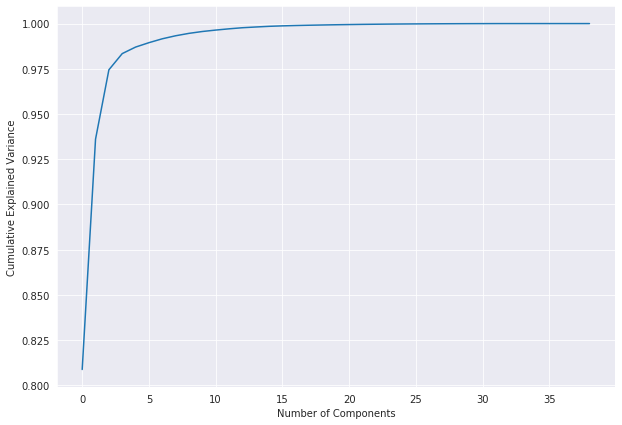

In [35]:
X = X.fillna(0)
pca_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
               'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH',#'LBH', 'LBD', 'LBA', 
               'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA',
               'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH',
               'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD',
               'PSCA']

pca = PCA().fit(X[pca_features])

sns.set_style("darkgrid")
plt.figure(figsize=(10, 7))
ax = sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [36]:
pca = PCA(n_components=12)
principalComponents = pca.fit_transform(X[pca_features])
pdf = pd.DataFrame(data = principalComponents)
pdf.columns = ['pc_'+str(x) for x in list(pdf)]
pdf.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11
0,4.124768,-4.055050,-4.071446,-0.227043,-1.291100,-0.709951,0.587661,-0.194658,-0.356517,0.263278,0.722988,-0.508781
1,-16.153835,20.118243,-2.184916,0.474701,-0.692014,-0.309831,-0.904181,0.301972,-0.278601,0.318873,0.000203,0.064128
2,26.301103,-0.396891,-3.914846,1.090594,-0.715137,1.676096,-2.269015,-1.717175,-0.097156,-0.087411,0.100138,-1.538718
3,-1.508275,-4.897451,-2.397114,2.329814,-1.235719,-0.763390,-1.265117,0.823162,-0.436681,0.291293,0.007741,-0.204939
4,0.490411,-4.723266,-1.358198,1.095163,-1.122963,0.016147,-1.350842,0.309176,-0.269951,0.185604,0.068452,-0.066762


In [37]:
pdf.shape

(569, 12)

In [38]:
pdf = pdf.join(X[[x for x in list(X) if x not in pca_features]])
pdf.shape

(569, 81)

In [39]:
Y = pdf['target']
X = pdf[[x for x in pdf.columns if x != 'target']]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 5, stratify=Y, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(455, 80)
(114, 80)
(455,)
(114,)


In [41]:
X_train.isnull().values.any()

False

In [42]:
scorer = make_scorer(f1_score)
clf_lr = LogisticRegression(class_weight='balanced')
param_dist = {'penalty': ['l1', 'l2'],
             'C': stats.uniform(0.001, 1)
             }

lr_rndm = RandomizedSearchCV(clf_lr, param_distributions = param_dist,
                         cv = 3, random_state = 12, n_iter = 1000,
                         scoring = scorer, error_score = 0,
                         verbose = 3, n_jobs = -1)

lr_rndm.fit(X_train, y_train)
print("Score: {}".format(lr_rndm.best_score_))
print(lr_rndm.best_estimator_)
print(lr_rndm.best_params_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2176 tasks      | elapsed:   18.6s


Score: 0.6601438116840004
LogisticRegression(C=0.09221923151081768, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
{'C': 0.09221923151081768, 'penalty': 'l1'}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   24.4s finished
/home/srooney/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train score: 0.703
Test score: 0.711
Test precision: 0.686
Test recall: 0.673
Test f1: 0.68


/home/srooney/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(91.68, 0.5, 'actual label')

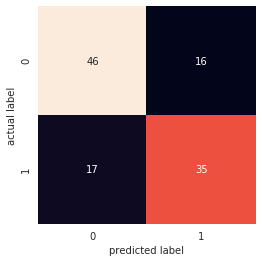

In [43]:
#lr_clf = LogisticRegression(penalty='l1', C=0.09, class_weight='balanced')
lr_clf = lr_rndm.best_estimator_
lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(f"Train score: {round(lr_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(lr_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, lr_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, lr_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, lr_y_pred), 3)}")

confmatrix = confusion_matrix(y_test, lr_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [44]:
eli5.show_weights(lr_clf, feature_names=list(X_train))

Weight?,Feature
+0.051,pc_0
+0.027,AtHomeWinStreak
+0.027,prev_HS
+0.019,HomeLosingStreak
+0.011,pc_2
+0.006,prev_HST
+0.002,prev_AC
+0.001,HomeUnbeatenStreak
-0.008,prev_AS
-0.025,prev_AST


In [45]:
scorer = make_scorer(f1_score)
clf_rf = RandomForestClassifier(random_state=12, n_jobs=-1, class_weight='balanced')
param_dist = {'bootstrap': [True, False],
             'n_estimators': stats.randint(100, 2000),
             'criterion': ['gini', 'entropy'],
             'max_depth': stats.randint(1, 150),
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': stats.randint(1, 100),
             'min_samples_split': stats.randint(1, 100),
             'max_leaf_nodes': stats.randint(1, 100)
             }

rf_rndm = RandomizedSearchCV(clf_rf, param_distributions = param_dist,
                         cv = 5, random_state = 12, n_iter = 300,
                         scoring = 'roc_auc', error_score = 0,
                         verbose = 3, n_jobs = -1)

rf_rndm.fit(X_train, y_train)
print("Score: {}".format(rf_rndm.best_score_))
print(rf_rndm.best_estimator_)
print(rf_rndm.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  7.9min finished
/home/srooney/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score: 0.7257064382440191
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=95, max_features='auto',
            max_leaf_nodes=5, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=26, min_weight_fraction_leaf=0.0,
            n_estimators=1967, n_jobs=-1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 95, 'max_features': 'auto', 'max_leaf_nodes': 5, 'min_samples_leaf': 4, 'min_samples_split': 26, 'n_estimators': 1967}


Train score: 0.741
Test score: 0.693
Test precision: 0.66
Test recall: 0.673
Test f1: 0.667


Text(91.68, 0.5, 'actual label')

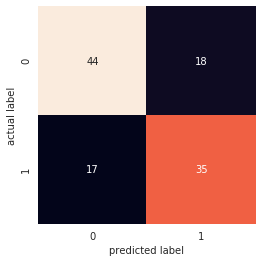

In [46]:
rf_clf = rf_rndm.best_estimator_
rf_clf.fit(X_train, y_train)

rf_y_pred = rf_clf.predict(X_test)

print(f"Train score: {round(rf_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(rf_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, rf_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, rf_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, rf_y_pred), 3)}")
      
rf_confmatrix = confusion_matrix(y_test, rf_y_pred)

sns.heatmap(rf_confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [47]:
eli5.show_weights(rf_clf, feature_names=list(X_train))

Weight,Feature
0.1912 ± 0.5213,pc_0
0.0650 ± 0.2665,pc_5
0.0565 ± 0.2456,pc_10
0.0438 ± 0.2004,pc_1
0.0430 ± 0.2213,VisitorWinStreak
0.0381 ± 0.2010,prev_HST
0.0373 ± 0.1964,pc_11
0.0363 ± 0.2094,VisitorLastWin
0.0360 ± 0.1942,pc_7
0.0349 ± 0.1869,prev_HS


In [48]:
perm = PermutationImportance(rf_clf).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=[x for x in pdf.columns if x != 'target'])

Weight,Feature
0.0475 ± 0.0346,pc_0
0.0171 ± 0.0102,prev_HS
0.0127 ± 0.0033,VisitorWPLast5
0.0114 ± 0.0151,VisitorLastWin
0.0110 ± 0.0062,prev_AST
0.0084 ± 0.0076,VisitorWinStreak
0.0079 ± 0.0022,VisitorLosingStreak
0.0070 ± 0.0076,pc_6
0.0066 ± 0.0108,pc_1
0.0053 ± 0.0082,prev_AS


In [49]:
scorer = make_scorer(f1_score)

clf_xgb = XGBClassifier(objective = 'binary:logistic', n_jobs=-1, random_state=12)
param_dist = {'n_estimators': stats.randint(100, 2000),
              'booster': ['gbtree', 'dart'],
              'learning_rate': stats.uniform(0.0001, 0.1),
              'gamma':stats.uniform(0.001, 10),
              'subsample': stats.uniform(0.1, 0.9),
              'max_depth': stats.randint(1, 150),
              'max_bin': stats.randint(4, 1000),
              'colsample_bytree': stats.uniform(0.1, 0.9),
              'min_child_weight': stats.randint(1, 100),
              'reg_alpha': stats.randint(2, 150),
              'reg_lambda': stats.randint(2, 150)
             }

xg_rndm = RandomizedSearchCV(clf_xgb, param_distributions = param_dist,
                         cv = 5, random_state = 12, n_iter = 500,
                         scoring = scorer, verbose = 3, n_jobs = -1)

xg_rndm.fit(X_train, y_train)
print("Score: {}".format(xg_rndm.best_score_))
print(xg_rndm.best_estimator_)
print(xg_rndm.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 503 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 791 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1143 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1559 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2039 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  9.8min finished
/home/srooney/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score: 0.6453712081231718
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8678834656054557, gamma=0.7247398904404924,
       learning_rate=0.003765298283429308, max_bin=743, max_delta_step=0,
       max_depth=36, min_child_weight=14, missing=None, n_estimators=1869,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=12, reg_alpha=3, reg_lambda=59, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.3482952394248854)
{'booster': 'gbtree', 'colsample_bytree': 0.8678834656054557, 'gamma': 0.7247398904404924, 'learning_rate': 0.003765298283429308, 'max_bin': 743, 'max_depth': 36, 'min_child_weight': 14, 'n_estimators': 1869, 'reg_alpha': 3, 'reg_lambda': 59, 'subsample': 0.3482952394248854}


Train score: 0.686
Test score: 0.763
Test precision: 0.766
Test recall: 0.692
Test f1: 0.727


Text(91.68, 0.5, 'actual label')

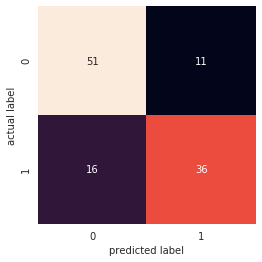

In [50]:
xg_clf = xg_rndm.best_estimator_

xg_clf.fit(X_train, y_train)

xg_y_pred = xg_clf.predict(X_test)

print(f"Train score: {round(xg_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(xg_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, xg_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, xg_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, xg_y_pred), 3)}")

confmatrix = confusion_matrix(y_test, xg_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [51]:
eli5.explain_weights_xgboost(xg_clf)

Weight,Feature
0.0683,pc_0
0.0437,HomeWPLast5
0.0422,prev_HS
0.0419,HomeLastWin
0.0411,VisitorLastWin
0.0409,VisitorWinStreak
0.0392,VisitorWPLast5
0.0385,AtHomeWinStreak
0.0372,prev_HST
0.0369,pc_3


In [52]:
scorer = make_scorer(f1_score)

params ={'n_estimators': stats.randint(1, 5000),
         'learning_rate': [0.005, 0.01, 0.1, 1],
         'num_iterations': stats.randint(1, 5000),
             'boosting_type':['gbdt', 'dart'],
             'max_depth': stats.randint(-1, 150),
             'max_bin': stats.randint(4, 500),
             'num_leaves': stats.randint(3, 200), 
             'min_child_samples': stats.randint(1, 500),
             'min_child_weight': stats.randint(0, 50),
             'subsample': stats.uniform(loc=0.2, scale=0.8),
             'colsample_bytree' : [0.65, 0.66, 0.8, 0.9],
             'reg_alpha': stats.randint(2, 200),
             'reg_lambda': stats.randint(2, 200)
            }

clf_lgbm = lgbm.LGBMClassifier(random_state=12, objective='binary',silent=True, 
                          metric='binary_error', n_jobs=-1)

lgbm_rndm = RandomizedSearchCV(clf_lgbm, param_distributions=params, 
                            n_iter=200, scoring=scorer, cv=5,
                            refit=True, random_state=12,verbose=1,n_jobs=-1)

lgbm_rndm.fit(X_train, y_train)
print("Score: {}".format(lgbm_rndm.best_score_))
print(lgbm_rndm.best_estimator_)
print(lgbm_rndm.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.0s finished
/home/srooney/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Score: 0.6500525728084687
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.1, max_bin=182,
        max_depth=16, metric='binary_error', min_child_samples=149,
        min_child_weight=42, min_split_gain=0.0, n_estimators=360,
        n_jobs=-1, num_iterations=2856, num_leaves=161, objective='binary',
        random_state=12, reg_alpha=19, reg_lambda=72, silent=True,
        subsample=0.5274657142794588, subsample_for_bin=200000,
        subsample_freq=0)
{'boosting_type': 'gbdt', 'colsample_bytree': 0.66, 'learning_rate': 0.1, 'max_bin': 182, 'max_depth': 16, 'min_child_samples': 149, 'min_child_weight': 42, 'n_estimators': 360, 'num_iterations': 2856, 'num_leaves': 161, 'reg_alpha': 19, 'reg_lambda': 72, 'subsample': 0.5274657142794588}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train score: 0.681
Test score: 0.763
Test precision: 0.766
Test recall: 0.692
Test f1: 0.727


Text(91.68, 0.5, 'actual label')

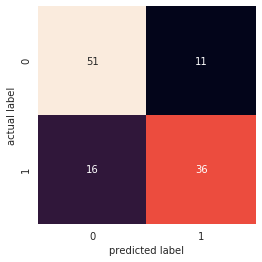

In [53]:
lgbm_clf = lgbm_rndm.best_estimator_

lgbm_clf.fit(X_train, y_train)

lgbm_y_pred = lgbm_clf.predict(X_test)

print(f"Train score: {round(lgbm_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(lgbm_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, lgbm_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, lgbm_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, lgbm_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, lgbm_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [54]:
from eli5.lightgbm import explain_weights_lightgbm
explain_weights_lightgbm(lgbm_clf)

Weight,Feature
0.9699,pc_0
0.0285,VisitorLastWin
0.0010,VisitorWinStreak
0.0005,prev_HS
0,VisitorLosingStreak
0,prev_AS
0,prev_HST
0,prev_AST
0,prev_AC
0,HomeWPLast5


In [55]:
svc = SVC(probability=True)
import scipy

parameter_space = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf', 'poly', 'linear'], 'degree': stats.randint(1, 10),'class_weight':['balanced', None]}

svc_rndm = RandomizedSearchCV(svc, param_distributions=parameter_space, 
                            n_iter=20, scoring=scorer, cv=5,
                            refit=True, random_state=12,verbose=1,n_jobs=-1)

svc_rndm.fit(X_train, y_train)
print("Score: {0: .4f}".format(svc_rndm.best_score_))
print(svc_rndm.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.6min finished
/home/srooney/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score:  0.6249
SVC(C=60.889964533615135, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.037091526412989864,
  kernel='poly', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


Train score: 0.8
Test score: 0.667
Test precision: 0.63
Test recall: 0.654
Test f1: 0.642


Text(91.68, 0.5, 'actual label')

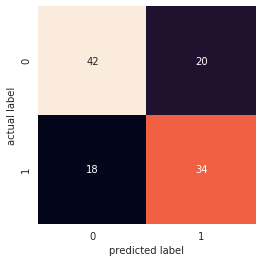

In [56]:
svc_clf = svc_rndm.best_estimator_
svc_clf.fit(X_train, y_train)

svc_y_pred = svc_clf.predict(X_test)

print(f"Train score: {round(svc_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(svc_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, svc_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, svc_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, svc_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, svc_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [57]:
eli5.show_weights(svc_clf, feature_names=list(X_train))

Train score: 0.695
Test score: 0.763
Test precision: 0.778
Test recall: 0.673
Test f1: 0.722


Text(91.68, 0.5, 'actual label')

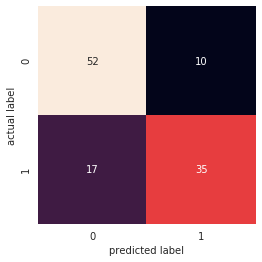

In [61]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('lg', lgbm_clf), ('xg', xg_clf), ('rf', rf_clf), ('lr', lr_clf)],
                        voting='hard', n_jobs=-1)

eclf = eclf.fit(X_train, y_train)

e_y_pred = eclf.predict(X_test)

print(f"Train score: {round(eclf.score(X_train, y_train), 3)}")
print(f"Test score: {round(eclf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, e_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, e_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, e_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, e_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [62]:
xpbs = X.copy()

In [63]:
def undummy(d):
    return d.dot(d.columns)

xpbs = xpbs.assign(HomeTeam=xpbs.filter(regex='^HomeTeam').pipe(undummy))
xpbs = xpbs.assign(AwayTeam=xpbs.filter(regex='^AwayTeam').pipe(undummy))

In [64]:
rf_probs = rf_clf.predict_proba(X)
rf_probs = [x[1] for x in rf_probs]
xgprobs = xg_clf.predict_proba(X)
xgprobs = [x[1] for x in xgprobs]
lgbmprobs = lgbm_clf.predict_proba(X)
lgbmprobs = [x[1] for x in lgbmprobs]
lrprobs = lr_clf.predict_proba(X)
lrprobs = [x[1] for x in lrprobs]
epreds = eclf.predict(X)
xpbs["xg_probs"] = xgprobs
xpbs["rf_probs"] = rf_probs
xpbs["lgbm_probs"] = lgbmprobs
xpbs["lr_probs"] = lrprobs
xpbs["ens_preds"] = epreds
xpbs["actual"] = y_test
xpbs[[x for x in list(xpbs) if 'pc_' not in x]]

,HomeLastWin,VisitorLastWin,HmLasthlll,VisLasthlll,Hmdwl,Visdwl,HomeWinStreak,VisitorWinStreak,HomeUnbeatenStreak,VisitorUnbeatenStreak,...,AwayTeam_West Ham,AwayTeam_Wolves,HomeTeam,AwayTeam,xg_probs,rf_probs,lgbm_probs,lr_probs,ens_preds,actual
0,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Arsenal,AwayTeam_Leicester,0.580353,0.581357,0.574063,0.608047,1,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Brighton,AwayTeam_Man City,0.348044,0.371229,0.363930,0.155577,0,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Chelsea,AwayTeam_Burnley,0.576692,0.585881,0.574063,0.780140,1,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Crystal Palace,AwayTeam_Huddersfield,0.573693,0.539270,0.574063,0.486126,1,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Everton,AwayTeam_Fulham,0.576938,0.535222,0.574063,0.524746,1,NaN
5,0,0,0,0,0,0,0,0,0,0,...,0,1,HomeTeam_Southampton,AwayTeam_Wolves,0.576938,0.524436,0.574063,0.527273,1,NaN
6,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Watford,AwayTeam_Liverpool,0.349542,0.392139,0.363930,0.276208,0,NaN
7,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Cardiff,AwayTeam_Bournemouth,0.398193,0.477133,0.392632,0.460687,0,NaN
8,0,0,0,0,0,0,0,0,0,0,...,1,0,HomeTeam_Man United,AwayTeam_West Ham,0.577489,0.569323,0.574063,0.686097,1,NaN
9,0,0,0,0,0,0,0,0,0,0,...,0,0,HomeTeam_Newcastle,AwayTeam_Tottenham,0.346490,0.417884,0.363930,0.301150,0,0.0


In [65]:
xpbs.loc[(xpbs['ens_preds'] == 1) & (xpbs['actual'] == 1)]

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,AwayTeam_West Ham,AwayTeam_Wolves,HomeTeam,AwayTeam,xg_probs,rf_probs,lgbm_probs,lr_probs,ens_preds,actual
0,4.124768,-4.055050,-4.071446,-0.227043,-1.291100,-0.709951,0.587661,-0.194658,-0.356517,0.263278,...,0,0,HomeTeam_Arsenal,AwayTeam_Leicester,0.580353,0.581357,0.574063,0.608047,1,1.0
13,11.836903,-2.632199,3.468478,2.199360,-0.779703,0.556986,0.480373,-0.008235,-0.235123,0.082605,...,0,0,HomeTeam_Liverpool,AwayTeam_Crystal Palace,0.602055,0.599163,0.574736,0.684227,1,1.0
14,-0.699456,-4.638520,2.376575,2.447259,0.346435,-0.138599,0.573812,-0.341959,0.336372,0.233265,...,1,0,HomeTeam_Southampton,AwayTeam_West Ham,0.598076,0.554332,0.574736,0.683322,1,1.0
30,11.215647,-1.948666,10.714201,2.972772,-3.661878,-2.067124,0.354188,-0.203480,-0.115320,0.678496,...,0,0,HomeTeam_Arsenal,AwayTeam_Bournemouth,0.584892,0.675762,0.574063,0.725030,1,1.0
34,-3.416779,-4.153184,7.925907,2.818724,-1.719668,-0.428422,0.540773,-0.091443,0.588802,-0.368375,...,0,0,HomeTeam_Man City,AwayTeam_Liverpool,0.561403,0.521682,0.557320,0.460710,1,1.0
59,14.347227,-2.338710,-0.713115,3.207537,-0.618047,-0.696627,-0.065704,-0.006457,0.565418,0.613958,...,0,0,HomeTeam_Arsenal,AwayTeam_Cardiff,0.585891,0.630571,0.574063,0.730068,1,1.0
108,6.798984,-2.640854,6.913887,-1.273649,-3.795057,-0.910700,0.370725,1.165628,0.895892,-0.602675,...,0,0,HomeTeam_Man City,AwayTeam_Arsenal,0.591629,0.671988,0.557320,0.642063,1,1.0
129,-1.862568,-4.382072,7.891167,-0.215279,-0.505490,-0.413803,-1.442545,0.452887,0.088490,0.290344,...,0,0,HomeTeam_Southampton,AwayTeam_Everton,0.573021,0.491592,0.574063,0.541325,1,1.0
134,35.071547,2.067566,5.011400,-0.066749,0.189570,-1.504333,-0.258085,-1.461435,-1.100393,2.484385,...,0,0,HomeTeam_Arsenal,AwayTeam_Huddersfield,0.615043,0.777080,0.574736,0.936671,1,1.0
155,18.097487,-1.084676,-0.198130,-3.074047,-1.073873,0.015281,1.318036,0.298106,-0.918999,0.193475,...,0,0,HomeTeam_Tottenham,AwayTeam_Fulham,0.565099,0.558922,0.556642,0.741388,1,1.0


In [66]:
xpbs[['HomeTeam', 'lr_probs', 'xg_probs', 'rf_probs', 'lgbm_probs']].groupby('HomeTeam').describe()

lr_probs                                          \
                           count      mean       std       min       25%   
HomeTeam                                                                   
HomeTeam_Arsenal            29.0  0.635333  0.177059  0.275772  0.511036   
HomeTeam_Bournemouth        29.0  0.443724  0.133221  0.135316  0.386069   
HomeTeam_Brighton           28.0  0.377135  0.098848  0.155577  0.307743   
HomeTeam_Burnley            28.0  0.371970  0.136402  0.084489  0.319205   
HomeTeam_Cardiff            29.0  0.371315  0.134985  0.028896  0.311110   
HomeTeam_Chelsea            29.0  0.678909  0.207500  0.210090  0.562379   
HomeTeam_Crystal Palace     28.0  0.423185  0.159647  0.015683  0.274858   
HomeTeam_Everton            29.0  0.472897  0.146433  0.132172  0.336623   
HomeTeam_Fulham             28.0  0.397483  0.144851  0.075839  0.305127   
HomeTeam_Huddersfield       29.0  0.370210  0.142285  0.031210  0.282953   
HomeTeam_Leicester          28.0  0.438529  0.148444  0.091086  0.325663   
HomeTeam_Liverpool          28.0  0.739946  0.190637  0.317172  0.638413   
HomeTeam_Man City           29.0  0.856177  0.150827  0.460710  0.834512   
HomeTeam_Man United         28.0  0.654055  0.216408  0.112823  0.494586   
HomeTeam_Newcastle          29.0  0.414414  0.138465  0.011264  0.310685   
HomeTeam_Southampton        27.0  0.472619  0.117681  0.212870  0.396379   
HomeTeam_Tottenham          27.0  0.689478  0.182192  0.284176  0.539655   
HomeTeam_Watford            29.0  0.414488  0.150449  0.084249  0.284212   
HomeTeam_West Ham           29.0  0.400566  0.142718  0.104349  0.315100   
HomeTeam_Wolves             29.0  0.392732  0.198801  0.023294  0.175441   

                                                      xg_probs            ...  \
                              50%       75%       max    count      mean  ...   
HomeTeam                                                                  ...   
HomeTeam_Arsenal         0.650897  0.743290  0.936671     29.0  0.533092  ...   
HomeTeam_Bournemouth     0.475202  0.537842  0.631266     29.0  0.437485  ...   
HomeTeam_Brighton        0.388141  0.432881  0.584664     28.0  0.381188  ...   
HomeTeam_Burnley         0.389592  0.461308  0.579862     28.0  0.388317  ...   
HomeTeam_Cardiff         0.405300  0.460687  0.608051     29.0  0.383636  ...   
HomeTeam_Chelsea         0.723938  0.825149  0.954454     29.0  0.551912  ...   
HomeTeam_Crystal Palace  0.480970  0.517557  0.661536     28.0  0.444213  ...   
HomeTeam_Everton         0.499387  0.591763  0.671869     29.0  0.482405  ...   
HomeTeam_Fulham          0.431784  0.505175  0.615580     28.0  0.396693  ...   
HomeTeam_Huddersfield    0.401554  0.477523  0.595979     29.0  0.375356  ...   
HomeTeam_Leicester       0.484760  0.541153  0.675143     28.0  0.471992  ...   
HomeTeam_Liverpool       0.803797  0.901706  0.974815     28.0  0.559841  ...   
HomeTeam_Man City        0.922740  0.968799  0.991090     29.0  0.602487  ...   
HomeTeam_Man United      0.707128  0.808512  0.923471     28.0  0.552784  ...   
HomeTeam_Newcastle       0.435127  0.509727  0.601082     29.0  0.421708  ...   
HomeTeam_Southampton     0.502466  0.541485  0.683322     27.0  0.477794  ...   
HomeTeam_Tottenham       0.754570  0.816065  0.886649     27.0  0.545836  ...   
HomeTeam_Watford         0.460260  0.557555  0.621403     29.0  0.424127  ...   
HomeTeam_West Ham        0.429450  0.515032  0.636236     29.0  0.425264  ...   
HomeTeam_Wolves          0.461563  0.534729  0.655833     29.0  0.412568  ...   

                         rf_probs           lgbm_probs                      \
                              75%       max      count      mean       std   
HomeTeam                                                                     
HomeTeam_Arsenal         0.678203  0.784538       29.0  0.512421  0.097102   
HomeTeam_Bournemouth     0.531707  0.561730       29.0  0.439076  0.093432   
HomeTeam_Brighton    

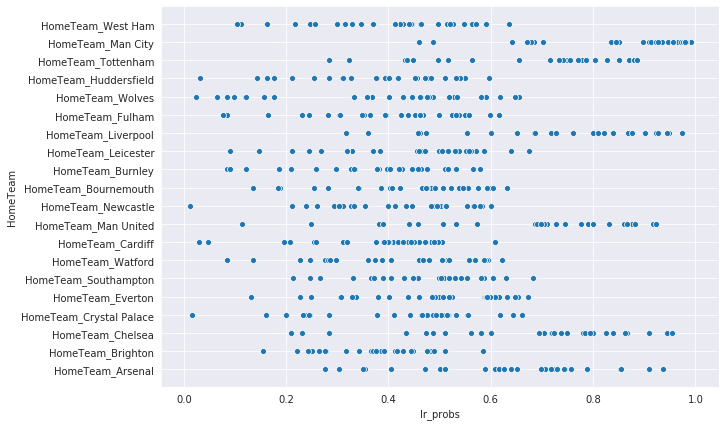

In [68]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x="lr_probs", y="HomeTeam", data=xpbs)